In [1]:
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
from MyDeepAR import *

In [2]:
data = pd.read_excel('data/副本泗洪各行业分时电量.xlsx')
data.head()

,行业大类一级分类,日期,0点至1点,1点至2点,2点至3点,3点至4点,4点至5点,5点至6点,6点至7点,7点至8点,...,15点至16点,16点至17点,17点至18点,18点至19点,19点至20点,20点至21点,21点至22点,22点至23点,23点至24点,日总用电量（kwh）
0,乡村居民,20220524,21245.5,20853.17,19775.03,19136.84,22515.24,33432.72,31639.20,23390.81,...,23887.39,26822.19,35066.01,42508.45,39721.10,31952.29,38755.83,31922.29,19693.59,682834.38
1,交通运输、仓储和邮政业,20220524,4217.43,4157.08,4408.31,3752.85,4192.95,4248.07,4554.87,4606.00,...,5534.98,5736.22,6105.60,5372.12,5100.14,4842.62,4762.83,4878.28,3079.65,114908.17
2,住宿和餐饮业,20220524,2960.76,2717.79,2601.92,2361.45,2718.60,2989.72,3160.66,3774.71,...,4555.35,5214.02,5642.20,6024.44,5997.94,5441.51,4884.29,4173.58,2517.34,103530.11
3,信息传输、软件和信息技术服务业,20220524,22515.64,22658.45,22306.05,22552.94,22236.90,22406.61,22883.72,23290.97,...,26381.78,26483.43,26911.13,27029.69,25277.67,23875.78,26453.15,25907.33,12578.95,580399.99
4,公共服务及管理组织,20220524,17080.04,17168.58,16280.63,16242.59,16167.59,17044.28,20403.14,23944.98,...,35238.95,34649.83,29733.87,26624.29,27794.47,26044.32,25668.84,23394.66,14821.49,626463.44


In [3]:
cats = ['乡村居民', 
'交通运输、仓储和邮政业', 
'住宿和餐饮业', 
'信息传输、软件和信息技术服务业',
'公共服务及管理组织',
'农、林、牧、渔业',
'城镇居民',
'工业',
'建筑业',
'房地产业',
'批发和零售业',
'租赁和商务服务业',
'金融业']
cats_len = len(cats)
# 分别获得各个行业数据
index = data.columns[2:]
data_cats = [ data[data['行业大类一级分类']  == cat].reset_index() for cat in cats]

for i in range(len(cats)):
    print(data_cats[i].shape)

# # 分析确实的数据
# for idx,cat in enumerate(data['行业大类一级分类']):
#     if cat != cats[idx%cats_len]:
#         print(idx)

# 对各个行业数据依次处理
for data_cat in data_cats:
    # 获得第i时刻的数据
    for idx in index:
        ### 提取平均值并替换掉str和异常值
        # 提取useful_data
        useful_data = []
        for i in data_cat[idx]:
            if type(i) == str:
                continue
            if float(i):
                useful_data.append(i)
        
        # 异常值识别并求取mean
        Q1 = np.quantile(useful_data, 0.25)
        Q3 = np.quantile(useful_data, 0.75)
        IQR = Q3 - Q1
        k = 0.5
        point_max = Q3 + k*IQR
        point_min = max(Q1 - k*IQR, 0)
        useful_data  = np.array(useful_data)
        mean = useful_data[(useful_data<point_max) & (useful_data>point_min)].mean()    
        # 替换掉data_cat 中 idx处的值
        replace_data = []
        for i in data_cat[idx]:
            if type(i) == str:
                replace_data.append(mean)
            elif (float(i)>point_min) & (float(i)<point_max):
                replace_data.append(i)
            else:
                replace_data.append(mean)

        data_cat[idx] = replace_data

(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)


### 分析各行业负荷调度潜力
cats = ['乡村居民', 
'交通运输、仓储和邮政业', 
'住宿和餐饮业', 
'信息传输、软件和信息技术服务业',
'公共服务及管理组织',
'农、林、牧、渔业',
'城镇居民',
'工业',
'建筑业',
'房地产业',
'批发和零售业',
'租赁和商务服务业',
'金融业']

In [4]:
print(np.array(data_cats[1].iloc[:,3:-1]).reshape(-1).shape)
analysis_idx = 0
# 构造时间序列数据
load = np.array(data_cats[analysis_idx].iloc[:,3:-1]).reshape(-1)
# time_index.dt
time_index = pd.date_range(start='20220524',end='20230513 23:00:00',freq='h')

load_data = pd.DataFrame({
    'time':time_index,
    'load':load
})
load_data['year'] = load_data['time'].dt.year
load_data['week'] = load_data['time'].dt.weekday
load_data['month'] = load_data['time'].dt.month
load_data['hour'] = load_data['time'].dt.hour
load_data['Time_index'] = load_data['time'].dt.day*24 + load_data['time'].dt.hour
load_data.index = time_index 
load_data = load_data.loc['2022-05-24 00:00:00':'2023-03-30 23:00:00']

weather_data = pd.read_csv('data/泗洪气象数据.csv')
print(load_data.shape, weather_data.shape)
# 添加气象数据在load_data中
'''
temperature_2m  温度
total_precipitation_hourly  降水
surface_pressure  大气压力
'''
load_data['temp'] = np.array(weather_data['temperature_2m'])
load_data['precipitation'] = np.array(weather_data['total_precipitation_hourly'])
load_data['pressure'] = np.array(weather_data['surface_pressure'])
load_data['load'] = load_data['load']/1000  # 单位为MW

(8520,)
(7464, 7) (7464, 10)


In [5]:
load_data.head()
load_data.loc['2022-06-1 00:00:00':'2023-03-30 23:00:00']

,time,load,year,week,month,hour,Time_index,temp,precipitation,pressure
2022-06-01 00:00:00,2022-06-01 00:00:00,24.66976,2022,2,6,0,24,298.594940,0.0,100238.8086
2022-06-01 01:00:00,2022-06-01 01:00:00,23.32940,2022,2,6,1,25,300.483963,0.0,100240.5859
2022-06-01 02:00:00,2022-06-01 02:00:00,21.65819,2022,2,6,2,26,302.174927,0.0,100230.9258
2022-06-01 03:00:00,2022-06-01 03:00:00,20.71108,2022,2,6,3,27,303.698746,0.0,100195.2188
2022-06-01 04:00:00,2022-06-01 04:00:00,22.18054,2022,2,6,4,28,304.892944,0.0,100156.6328
...,...,...,...,...,...,...,...,...,...,...
2023-03-30 19:00:00,2023-03-30 19:00:00,43.73827,2023,3,3,19,739,282.623840,0.0,101618.1133
2023-03-30 20:00:00,2023-03-30 20:00:00,31.77163,2023,3,3,20,740,282.644028,0.0,101634.3047
2023-03-30 21:00:00,2023-03-30 21:00:00,32.78947,2023,3,3,21,741,282.687347,0.0,101634.2891
2023-03-30 22:00:00,2023-03-30 22:00:00,27.04811,2023,3,3,22,742,282.745529,0.0,101676.6719


### 挖掘可调负荷潜力

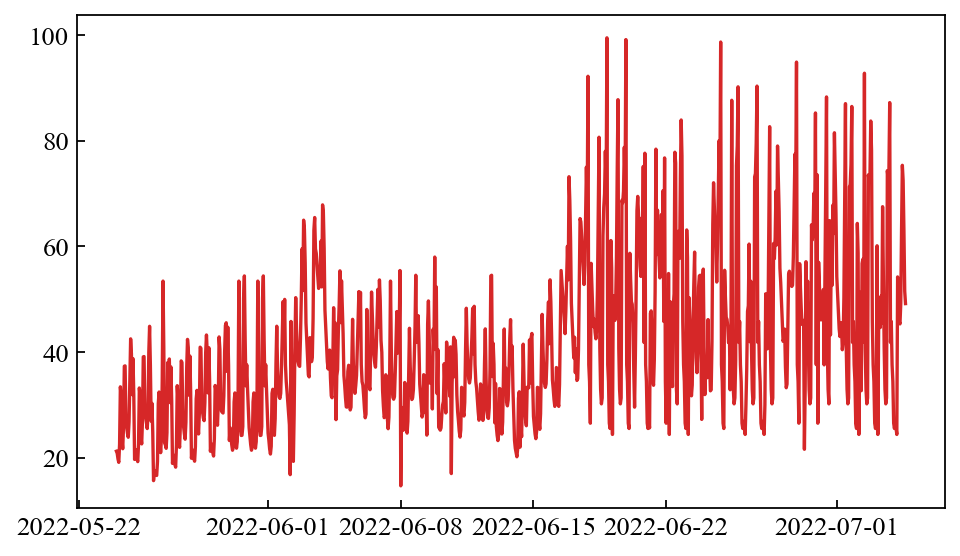

In [6]:
# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(7, 4))
ax = fig.add_subplot(111)
ax.plot(load_data['load'][0:1000], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值

### 如何分析各行业负荷潜力？
假设各行业可调潜力为a，基础用电量为(at+b)，其中t为温度，为温度的二次线性函数。
cats = ['乡村居民', '交通运输、仓储和邮政业', '住宿和餐饮业', '信息传输、软件和信息技术服务业', '公共服务及管理组织', '农、林、牧、渔业', '城镇居民', '工业', '建筑业', '房地产业', '批发和零售业', '租赁和商务服务业', '金融业']

农、林、牧、渔业


<Axes: >

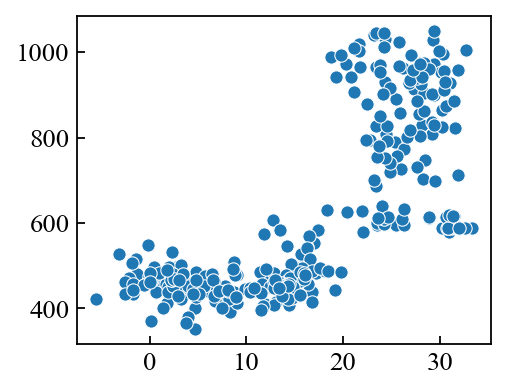

In [13]:
#  绘制用电量与温度关系曲线
analysis_idx = 5
print(cats[analysis_idx])
data_cats[analysis_idx].index = pd.date_range(start='20220524',end='20230513 23:00:00',freq='d')
load_idx = np.array(data_cats[analysis_idx].loc['2022-05-24 00:00:00':'2023-03-30 23:00:00'].iloc[:,3:-1]).sum(1)
temp = np.array(weather_data['temperature_2m']).reshape(-1,24).mean(1)

## 绘制散点图
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=temp-273.15
y=load_idx/1000
sns.scatterplot(x=x, y=y)


[1.93343545e-01 7.34031625e+00 4.14520760e+02] 1


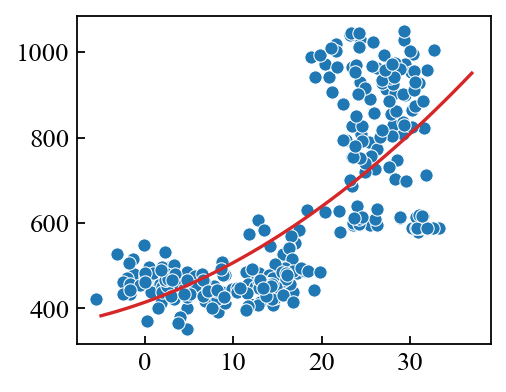

In [14]:
### 拟合曲线，之后确定再确a
from scipy.optimize import leastsq

def function(x, a , b, c):
  
    y = a*x**2 + b*x +c
    return y

def f_err(p, y, x):
    return  y - function(x, *p)

coeff, ret_val = leastsq(f_err, [1, 1, 1], args=(y, x))
a, b, c = coeff
print(coeff, ret_val)


# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=temp-273.15
y=load_idx/1000
sns.scatterplot(x=x, y=y, ax=ax, color=color_list[1])

ax.plot(np.arange(-5,38), function(np.arange(-5,38), *coeff), color=color_list[4])

In [310]:
from scipy.optimize import minimize
# p[0] 为截距
def min_function(p):
    global a, b, x, y
    yu = a*x**2 + b*x +p[0]  # 上界
    yl = (a*x**2 + b*x +p[0])*(1-p[1])  # 下界
    return (yl-yu + abs(yl-y) + abs(y-yu)).sum() + (abs(yu-yl)*0.5).sum()

bnds = ((0, None), (0, 0.5))
res = minimize(min_function, (47, 3), method='SLSQP', bounds=bnds)
res.x

array([0.75192274, 0.20080934])

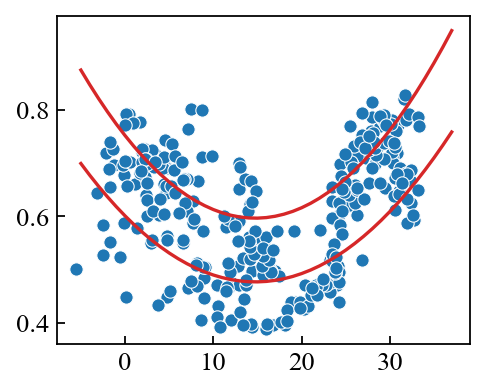

In [311]:
def function(x,c):
  
    y = a*x**2 + b*x +c
    return y


# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=temp-273.15
y=load_idx/1000
sns.scatterplot(x=x, y=y, ax=ax, color=color_list[1])

ax.plot(np.arange(-5,38), function(np.arange(-5,38), res.x[0]), color=color_list[4])
ax.plot(np.arange(-5,38),  ( 1-res.x[1])*function(np.arange(-5,38),  res.x[0]), color=color_list[4])

### 线性分析

<Axes: >

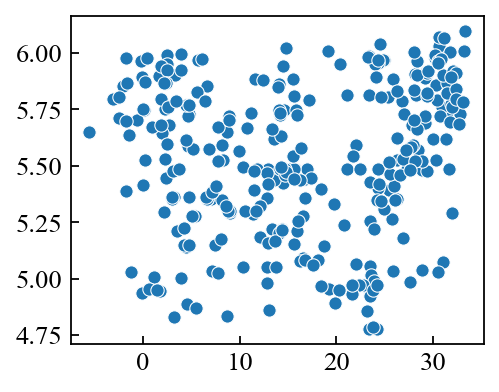

In [265]:
#  绘制用电量与温度关系曲线
analysis_idx = 1
data_cats[analysis_idx].index = pd.date_range(start='20220524',end='20230513 23:00:00',freq='d')
load_idx = np.array(data_cats[analysis_idx].loc['2022-05-24 00:00:00':'2023-03-30 23:00:00'].iloc[:,3:-1]).mean(1)
temp = np.array(weather_data['temperature_2m']).reshape(-1,24).mean(1)

# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=temp-273.15
y=load_idx/1000
sns.scatterplot(x=x, y=y)

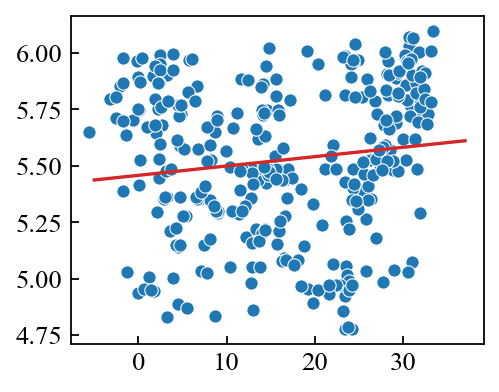

In [252]:
### 拟合曲线，之后确定再确a
def function(x, b, c):
    y = b*x +c
    return y

def f_err(p, y, x):
    return  y - function(x, *p)

coeff, ret_val = leastsq(f_err, [1, 1], args=(y, x))
b, c = coeff
coeff, ret_val


# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=temp-273.15
y=load_idx/1000
sns.scatterplot(x=x, y=y, ax=ax, color=color_list[1])

ax.plot(np.arange(-5,38), function(np.arange(-5,38), *coeff), color=color_list[4])

In [253]:
from scipy.optimize import minimize
# p[0] 为截距
def min_function(p):
    global a, b, x, y
    yu = b*x +p[0]  # 上界
    yl = (b*x +p[0])*(1-p[1])  # 下界
    return (yl-yu + abs(yl-y) + abs(y-yu)).sum() + (abs(yu-yl)*0.5).sum()

bnds = ((0, None), (0, 0.5))
res = minimize(min_function, (47, 3), method='SLSQP', bounds=bnds)
res.x

array([5.73613528, 0.08437665])

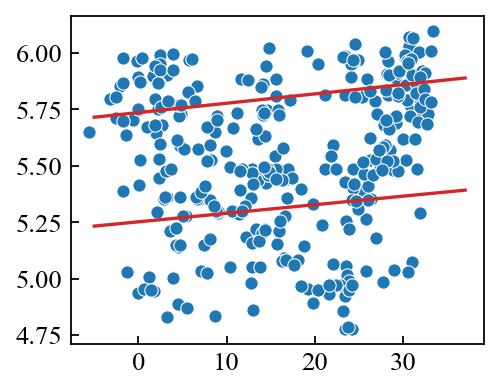

In [256]:
def function(x,c):
  
    y = b*x +c
    return y


# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=temp-273.15
y=load_idx/1000
sns.scatterplot(x=x, y=y, ax=ax, color=color_list[1])

ax.plot(np.arange(-5,38), function(np.arange(-5,38), res.x[0]), color=color_list[4])
ax.plot(np.arange(-5,38),  ( 1-res.x[1])*function(np.arange(-5,38),  res.x[0]), color=color_list[4])